### Import libraries

In [4]:
%pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/b1/79/0d1c165eac44405a86478082e225fce87874f7198300bbebc55faaf6d28d/matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata
  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/01/c8/fadd0b92ffa7b5eb5949bf340a63a4a496a6930a6c37a7ba0f12acb076d6/contourpy-1.3.2-cp312-cp312-win_amd64.whl.metadata
  Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/0e/4d/1eaaad22781d55f49d1b184563842172aeb6a4f


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt

### Load data for machine learning

In [6]:
# Path to your HDF5 file
hdf5_file = "train_data.h5"

# Open the HDF5 file
with h5py.File(hdf5_file, 'r') as hdf:
    # Extract the images (X)
    X = np.array(hdf['images'])
    
    # Extract the labels (y)
    y = np.array(hdf['labels'])

# Check the shapes to ensure they are correct
print("Shape of X (images):", X.shape)
print("Shape of y (labels):", y.shape)

hdf5_file_test = "test_data.h5"
# Open the HDF5 file
with h5py.File(hdf5_file_test, 'r') as hdf:
    # Extract the images (X)
    X_test = np.array(hdf['images'])

# Check the shapes to ensure they are correct
print("Shape of X_test (images):", X_test.shape)

Shape of X (images): (1100000, 16, 16, 6)
Shape of y (labels): (1100000,)
Shape of X_test (images): (120000, 16, 16, 6)


### Visualizing the data

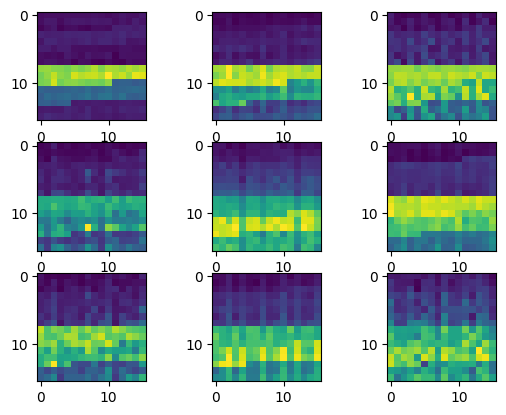

In [9]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[i][:, :,2], interpolation='nearest')
plt.show()

In [12]:
pixel = X[42][5][10]
print("Pixel values at (5, 10) in image 42:")
print(f"Blue: {pixel[0]}\nGreen: {pixel[1]}\nRed: {pixel[2]}")
print(f"NIR: {pixel[3]}\nSWIR1: {pixel[4]}\nSWIR2: {pixel[5]}")

Pixel values at (5, 10) in image 42:
Blue: 1591
Green: 1630
Red: 1601
NIR: 1608
SWIR1: 775
SWIR2: 790


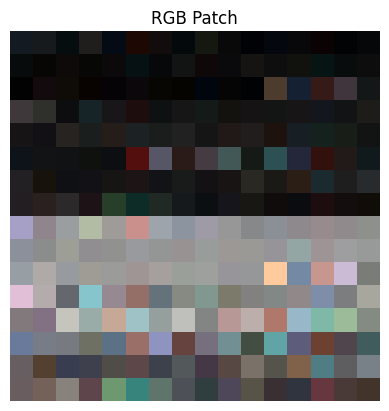

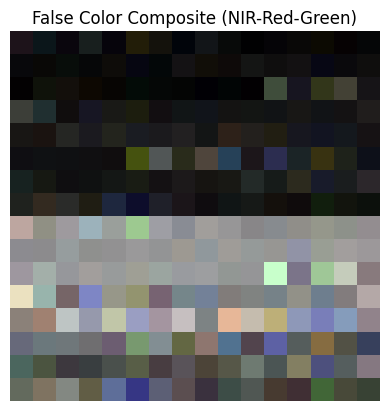

In [13]:
patch = X[0]

#print("RGB Composite:")
rgb = np.stack([patch[:, :, 2], patch[:, :, 1], patch[:, :, 0]], axis=-1)
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

plt.imshow(rgb)
plt.title("RGB Patch")
plt.axis('off')
plt.show()

#print("False Color (NIR-Red-Green, commonly used for vegetation)")
fc = np.stack([patch[:, :, 3], patch[:, :, 2], patch[:, :, 1]], axis=-1)
fc = (fc - fc.min()) / (fc.max() - fc.min())

plt.imshow(fc)
plt.title("False Color Composite (NIR-Red-Green)")
plt.axis('off')
plt.show()


### Balance data

In [3]:
# Step 1: Count the number of 1's in y
num_ones = np.sum(y == 1)

# Step 2: Get indices of 0's and 1's in y
ones_indices = np.where(y == 1)[0]
zeros_indices = np.where(y == 0)[0]

# Step 3: Randomly sample the same number of 0's as there are 1's
balanced_zero_indices = np.random.choice(zeros_indices, num_ones, replace=False)

# Step 4: Combine indices of 0's and 1's
balanced_indices = np.concatenate([ones_indices, balanced_zero_indices])

# Step 5: Create balanced X and y
X_balanced = X[balanced_indices]
y_balanced = y[balanced_indices]

# Display the number of 0's and 1's in the balanced y
print(f"Number of 1's in balanced y: {np.sum(y_balanced == 1)}")
print(f"Number of 0's in balanced y: {np.sum(y_balanced == 0)}")

Number of 1's in balanced y: 100000
Number of 0's in balanced y: 100000


In [4]:
from sklearn.utils import shuffle
# Shuffle both X_balanced and y_balanced together
X_train, y_train = shuffle(X_balanced, y_balanced, random_state=1)


In [5]:
print(X_train.shape)
print(X_test.shape)

(200000, 16, 16, 6)
(120000, 16, 16, 6)


### Baseline models
#### Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_test_flat = X_test.reshape(X_test.shape[0], -1)  

# Define and train the baseline model
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train_flat, y_train)

y_pred_train = rf.predict(X_train_flat)
y_pred_test = rf.predict(X_test_flat)


# Evaluate the model
train_accuracy_rf = accuracy_score(y_train, y_pred_train)

## 0.9999 accuracy: OVERFITTING
print(f'Baseline RF model training accuracy: {train_accuracy_rf:.4f}')


Baseline RF model training accuracy: 0.9999


#### Multi layer perceptron

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Scale the data to [0,1]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Define and train the MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=20, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_train_mlp = mlp_model.predict(X_train_scaled)
y_pred_test_mlp = mlp_model.predict(X_test_scaled)


# Evaluate the model
train_accuracy_mlp = accuracy_score(y_train, y_pred_train_mlp)


## ~0.60 accuracy: UNDERFITTING
print(f'Baseline MLP model training accuracy: {train_accuracy_mlp:.4f}')




/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Baseline MLP model training accuracy: 0.6053
